## Importing Libraries and data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle

import re
from tqdm import tqdm

from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import QuantileTransformer

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Data Cleaning

In [6]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


**Observation:**


    1. CustomerID can be dropped as its unique for each record
    2. Convert SeniorCitizen feature to categorical
    3. Convert TotalCharges feature to numeric

In [8]:
df.drop(columns=['customerID'], inplace=True)
df['SeniorCitizen'] = df['SeniorCitizen'].astype('str')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [9]:
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
df[df.TotalCharges.isnull()]['Churn']

488     No
753     No
936     No
1082    No
1340    No
3331    No
3826    No
4380    No
5218    No
6670    No
6754    No
Name: Churn, dtype: object

**Observation:** There are only 11 records with NA values and all belong to majority class. We can drop these records

In [12]:
df.dropna(inplace=True)

**Separating numerical and categorical variables**

In [14]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

categorical_cols, numeric_cols

(['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'Churn'],
 ['tenure', 'MonthlyCharges', 'TotalCharges'])

In [15]:
for feature in categorical_cols:
    print(feature, ' : ', df[feature].unique())

gender  :  ['Female' 'Male']
SeniorCitizen  :  [0 1]
Partner  :  ['Yes' 'No']
Dependents  :  ['No' 'Yes']
PhoneService  :  ['No' 'Yes']
MultipleLines  :  ['No phone service' 'No' 'Yes']
InternetService  :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  ['No' 'Yes' 'No internet service']
OnlineBackup  :  ['Yes' 'No' 'No internet service']
DeviceProtection  :  ['No' 'Yes' 'No internet service']
TechSupport  :  ['No' 'Yes' 'No internet service']
StreamingTV  :  ['No' 'Yes' 'No internet service']
StreamingMovies  :  ['No' 'Yes' 'No internet service']
Contract  :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  ['Yes' 'No']
PaymentMethod  :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn  :  ['No' 'Yes']


In [16]:
def clean_text(text):
    "preprocess text data"
    
    text = str(text).lower()
    text = re.sub(r'\(.*', ' ', text)
    text = text.strip()
    text = re.sub(r'[ -]', '_', text)
    
    return text

In [17]:
for feature in tqdm(categorical_cols):
    df[feature] = df[feature].apply(clean_text)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 88.76it/s]


In [18]:
for feature in categorical_cols:
    print(feature, ' : ', df[feature].unique())

gender  :  ['female' 'male']
SeniorCitizen  :  ['0' '1']
Partner  :  ['yes' 'no']
Dependents  :  ['no' 'yes']
PhoneService  :  ['no' 'yes']
MultipleLines  :  ['no_phone_service' 'no' 'yes']
InternetService  :  ['dsl' 'fiber_optic' 'no']
OnlineSecurity  :  ['no' 'yes' 'no_internet_service']
OnlineBackup  :  ['yes' 'no' 'no_internet_service']
DeviceProtection  :  ['no' 'yes' 'no_internet_service']
TechSupport  :  ['no' 'yes' 'no_internet_service']
StreamingTV  :  ['no' 'yes' 'no_internet_service']
StreamingMovies  :  ['no' 'yes' 'no_internet_service']
Contract  :  ['month_to_month' 'one_year' 'two_year']
PaperlessBilling  :  ['yes' 'no']
PaymentMethod  :  ['electronic_check' 'mailed_check' 'bank_transfer' 'credit_card']
Churn  :  ['no' 'yes']


In [19]:
# Take dump of cleaned data
df.to_csv('df_cleaned.csv', index=False)

## EDA

### Target variable

<Axes: xlabel='Churn', ylabel='count'>

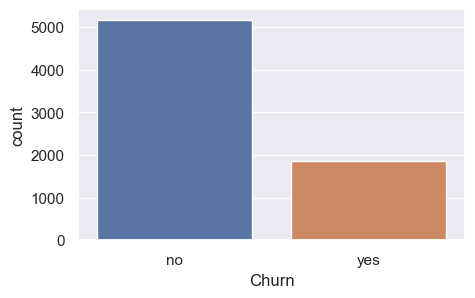

In [21]:
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='Churn')

**Observation:** Data is imbalanced

### Numeric variables

In [24]:
with open(r'.\dumps\numeric_columns.pkl', 'wb') as f:
    pickle.dump(numeric_cols,f)

In [25]:
df[numeric_cols].head(4)

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75


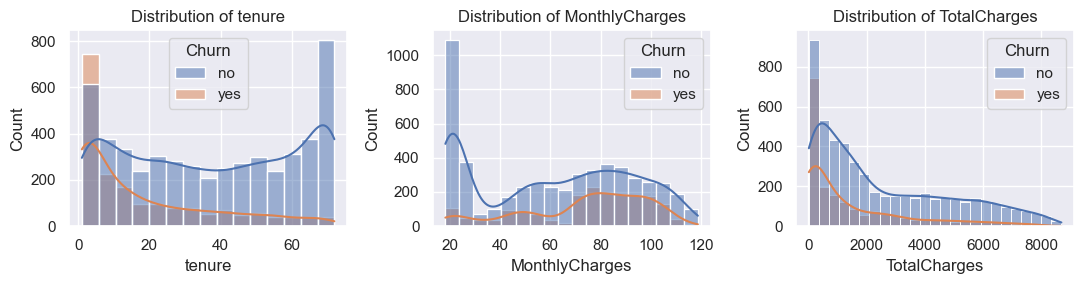

In [26]:
fig, axs = plt.subplots(1,3, figsize=(11,3))

for i, feature in enumerate(numeric_cols):
    sns.histplot(data=df, x=feature, hue='Churn', kde=True, ax=axs[i])
    axs[i].set_title(f"Distribution of {feature}")
plt.tight_layout()

**Observation**

- There are no outliers
- Churn rate is high for very low tenures like less than 5
- Churn rate increases as monthly charges increases in the range of 70-105 approx.
- Churn rate is high for lower TotalCharges
- There is No clear distribution distinction between the classes

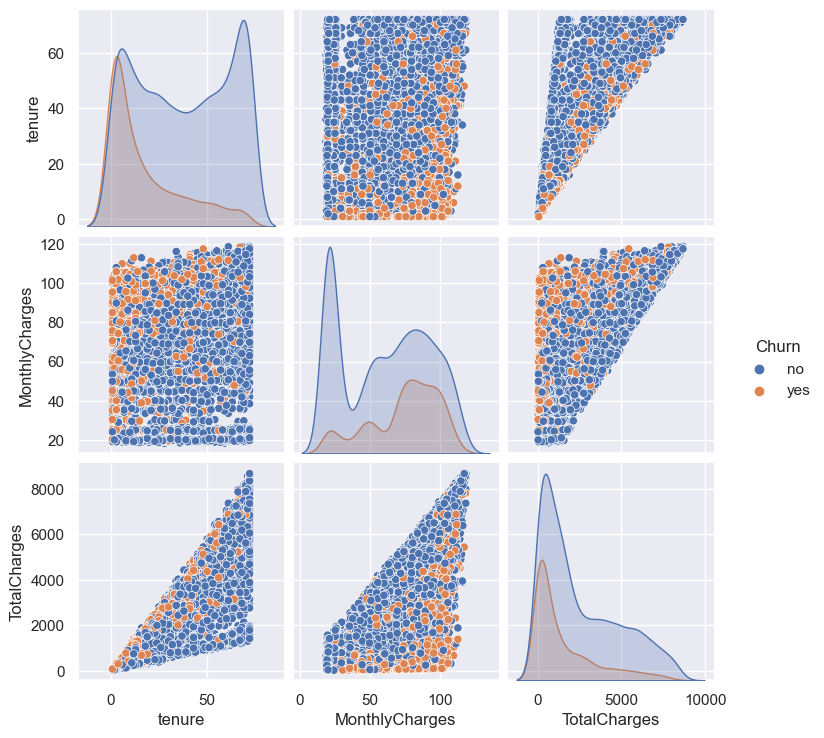

In [28]:
sns.pairplot(df, hue='Churn')

**Observation**

    - We can see that churn rate is high for lower tenures (<20) and higher monthly charges (>60)
    - Similarly, churn rate is high for lower Total charges (<3000) and higher monthly charges (>60)

**Correlation between numerical features**

<Axes: >

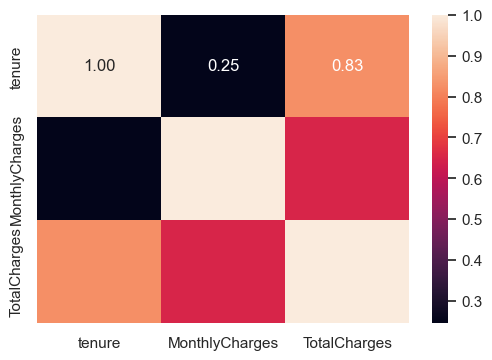

In [31]:
plt.figure(figsize=(6,4))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f')

**Observation:** There is a strong correlation between tenure and TotalCharges

**Correlation between numeric features and Target variable**

As anova assumes normal distribution of features. Lets transform the features

In [35]:
transformer = QuantileTransformer(output_distribution='normal')

df[['tenure_transformed', 'MonthlyCharges_transformed', 'TotalCharges_transformed']] = transformer.fit_transform(df[numeric_cols])

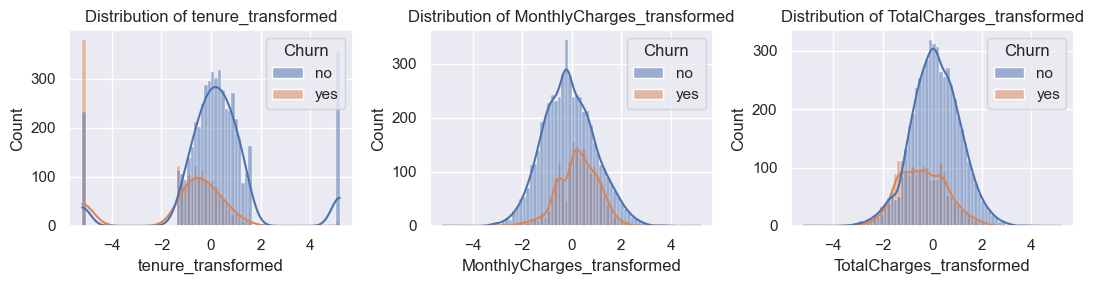

In [36]:
fig, axs = plt.subplots(1,3, figsize=(11,3))

for i, feature in enumerate(['tenure_transformed', 'MonthlyCharges_transformed', 'TotalCharges_transformed']):
    sns.histplot(data=df, x=feature, hue='Churn', kde=True, ax=axs[i])
    axs[i].set_title(f"Distribution of {feature}")
plt.tight_layout()

In [37]:
for feature in ['tenure_transformed', 'MonthlyCharges_transformed', 'TotalCharges_transformed']:
    anova_result = stats.f_oneway(*[df[df['Churn']==category][feature] for category in df['Churn'].unique()])
    
    print(feature, 'anova results:')
    print(f'F-statistic: {anova_result.statistic}')
    print(f'P-value: {anova_result.pvalue}')
    print('-'*50)

tenure_transformed anova results:
F-statistic: 914.566713232506
P-value: 5.604773230429133e-189
--------------------------------------------------
MonthlyCharges_transformed anova results:
F-statistic: 192.2976363933159
P-value: 3.694604511986785e-43
--------------------------------------------------
TotalCharges_transformed anova results:
F-statistic: 386.50849046367057
P-value: 8.233455741799643e-84
--------------------------------------------------


**Observation:** As p-values are less than 0.05 for all three features, there is strong association between these numerical features and target variable

In [95]:
df.groupby('Churn')[numeric_cols].mean().round(2)

,tenure,MonthlyCharges,TotalCharges
Churn,,,
no,37.65,61.31,2555.34
yes,17.98,74.44,1531.80


In [97]:
df.groupby('Churn')[['tenure_transformed', 'MonthlyCharges_transformed', 'TotalCharges_transformed']].mean().round(2)

,tenure_transformed,MonthlyCharges_transformed,TotalCharges_transformed
Churn,,,
no,0.29,-0.10,0.14
yes,-1.29,0.27,-0.38


We can see that churn rate is high for lower tenures, higher monthly charges and lower total charges

### Categorical variables

In [40]:
categorical_cols.remove('Churn')

with open(r'.\dumps\categorical_columns.pkl', 'wb') as f:
    pickle.dump(categorical_cols,f)

In [41]:
df[categorical_cols].head(4)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,female,0,yes,no,no,no_phone_service,dsl,no,yes,no,no,no,no,month_to_month,yes,electronic_check
1,male,0,no,no,yes,no,dsl,yes,no,yes,no,no,no,one_year,no,mailed_check
2,male,0,no,no,yes,no,dsl,yes,yes,no,no,no,no,month_to_month,yes,mailed_check
3,male,0,no,no,no,no_phone_service,dsl,yes,no,yes,yes,no,no,one_year,no,bank_transfer


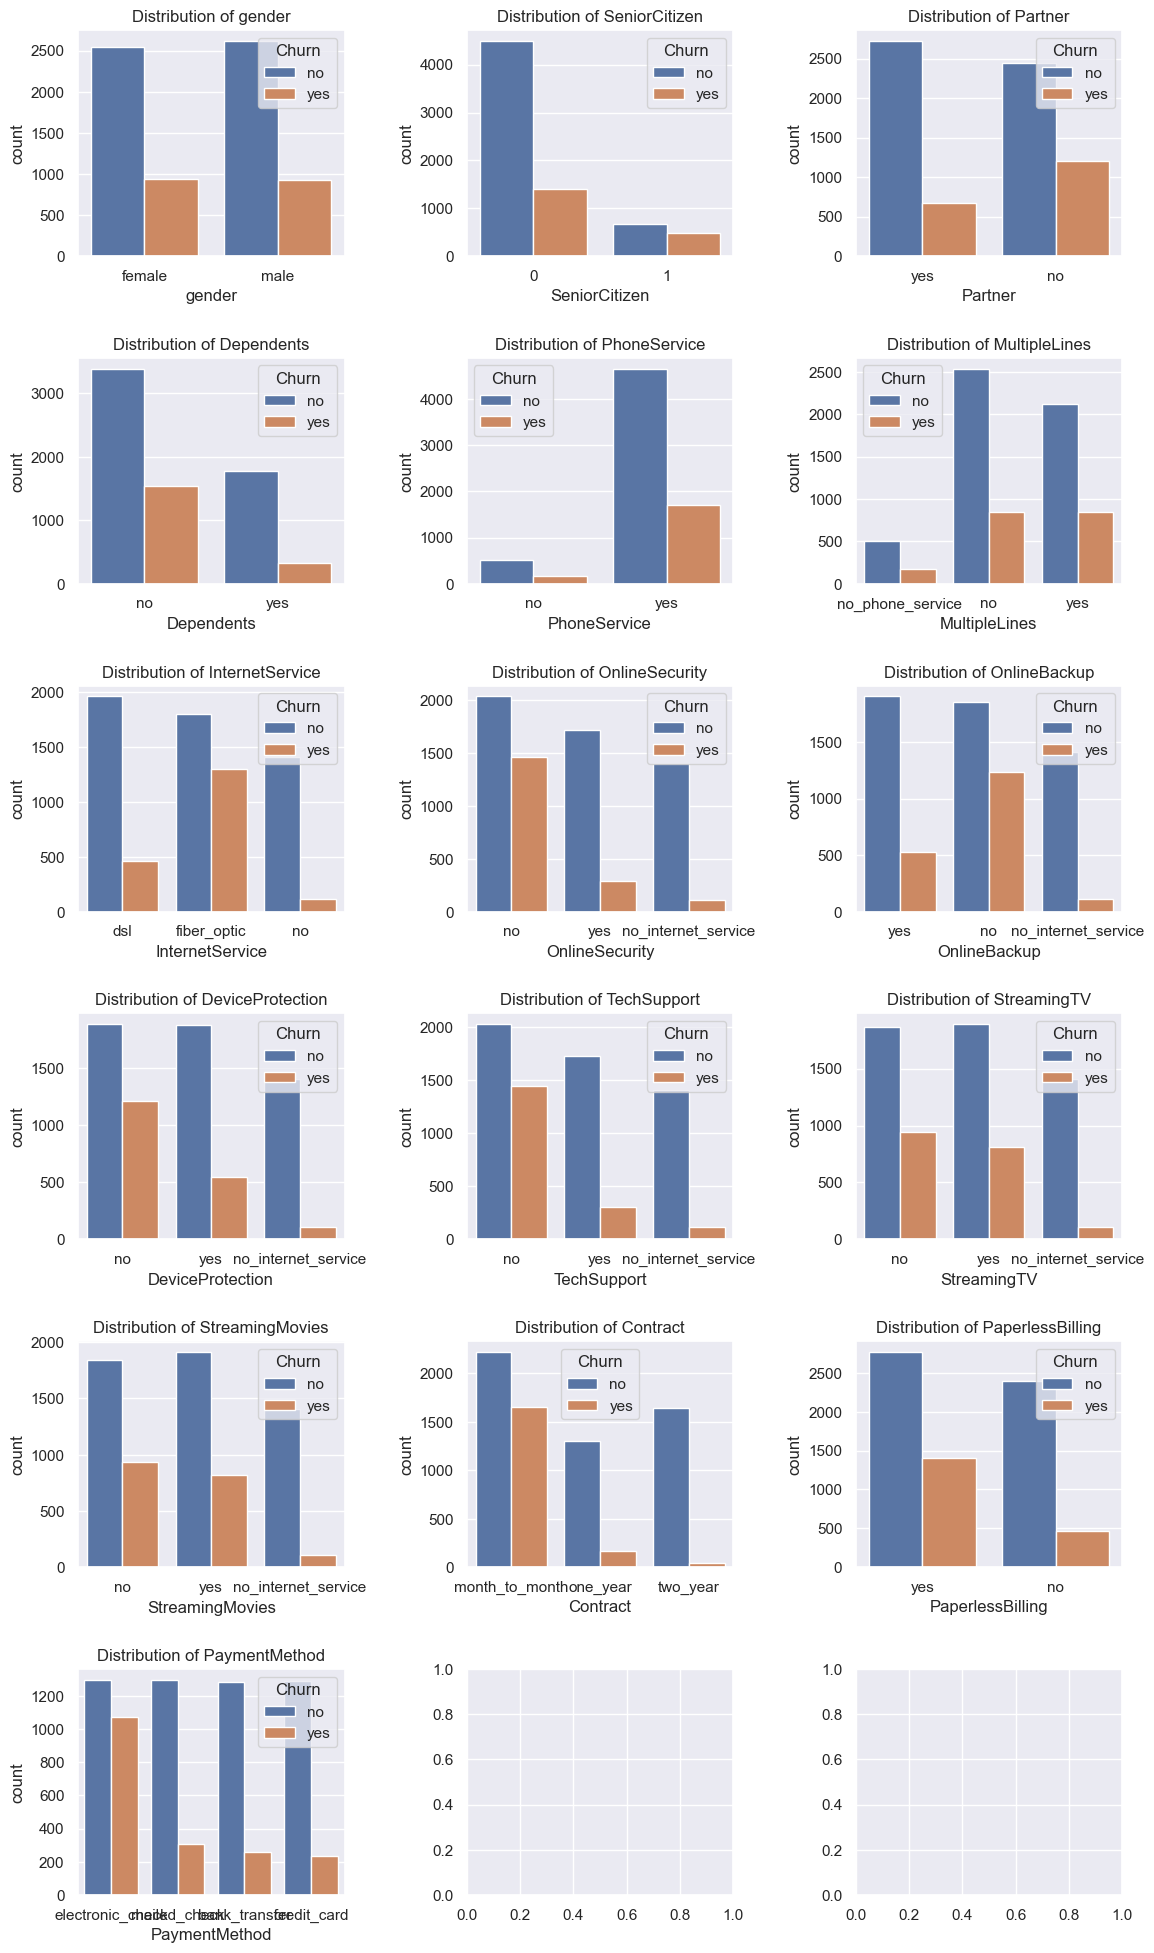

In [42]:
fig, axs = plt.subplots(6,3, figsize=(12,20))

i,j = 0,0 
for feature in categorical_cols:
    sns.countplot(data=df, x=feature, hue='Churn', ax=axs[i,j])
    axs[i,j].set_title(f"Distribution of {feature}")

    # Update indices
    j += 1
    if j >= 3:  # Move to the next row
        j = 0
        i += 1
plt.tight_layout(pad=2.0)

In [43]:
df[['PaymentMethod','Churn']].value_counts(normalize=True)

PaymentMethod     Churn
mailed_check      no       0.184300
electronic_check  no       0.184016
credit_card       no       0.183305
bank_transfer     no       0.182594
electronic_check  yes      0.152304
mailed_check      yes      0.043800
bank_transfer     yes      0.036689
credit_card       yes      0.032992
Name: proportion, dtype: float64

**Observation**
- Churn rate is high for seniorCitizen
- Churn rate is high for No partner comparitively
- Churn rate is high if there are No dependents
- Churn rate is high if InternetService is 'Fiber optic'
- Churn rate is high is ther is no OnlineSecurity
- Churn rate is high if there is No OnlineBackup
- Churn rate is high if there is No Device protection
- Churn rate is hihg if there is No Techsupport
- Churn rate is low if there is No internet service for Streaming TV and Streaming movies
- Churn rate is high for month-to-month contract
- Churn rate is comparitively higher for paperless billing
- Churn rate is high for Electronic Check payment method


**Features that seem more important from data exploration**

    Numeric
    - tenure
    - monthlyCharges

    Categorical
    - Contract
    - SeniorCitizen
    - Internet Service
    - Online Security
    - payment method
    - Online protection
    - tech support
    
     to name a few

**Now lets see statistically if there is significant association of categorical variables with target variable**

In [48]:
categorical_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [49]:
results = []
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    # print(contingency_table)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # print(f'Feature: {col}, p-value: {p}')
    results.append({'Feature': col,
                    'p-value': round(p,2)})
pd.DataFrame(results)

,Feature,p-value
0,gender,0.49
1,SeniorCitizen,0.00
2,Partner,0.00
3,Dependents,0.00
4,PhoneService,0.35
5,MultipleLines,0.00
6,InternetService,0.00
7,OnlineSecurity,0.00
8,OnlineBackup,0.00
9,DeviceProtection,0.00


**Observation:** Features 'gender' and 'PhoneService' are not associated with the target variable or not so useful for prediction